In [104]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [105]:
from collections import defaultdict
from itertools import count

import numpy as np


import matplotlib.pyplot as plt
import plotly.offline as py
from plotly.offline import init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import networkx as nx

In [106]:
file = "/home/ubuntu/data/tmp/karate/zkcc-77/karate_edges_78.txt"

In [121]:
class CommunityNetwork():
    def __init__(self, A):
        self._A = A
        
        self.number_of_nodes = self._A.shape[0]
        self.communities = np.array([i for i in range(self.number_of_nodes)], dtype=int)
        self._m = 0.5*np.sum(np.sum(A))
        self.modularity = self.compute_modularity()
        
        
    @staticmethod
    def create_adjacency_matrix(file):
        node_neighbors = defaultdict(list)

        with open(file, "r") as fin:
            for line in fin:
                node_1, node_2 = line.strip().split('\t')
                node_1 = int(node_1)-1 #offset to make the integers start from zero
                node_2 = int(node_2)-1
                node_neighbors[node_1].append(node_2)

        number_of_nodes = len(node_neighbors)
        A = np.zeros((number_of_nodes, number_of_nodes))

        for node, neighbors in node_neighbors.items():
            for neighbor in neighbors:
                A[node, neighbor] = 1

        return A
    
    def modularity_difference(self, nodei, communityi):
        #save community of node
        original_community = self.communities[nodei]
        #change community
        self.communities[nodei] = communityi
        #compute new modularity
        new_modularity = self.compute_modularity()
        #print(f"{nodei}, {communityi}, {self.modularity}, {new_modularity}")
        modularity_difference = new_modularity-self.modularity
        #restore community
        self.communities[nodei] = original_community
        return modularity_difference
    
    def find_best_community(self, nodei):
        unique_communities = np.unique(self.communities)
        max_modularity_difference = 0
        best_community = self.communities[nodei]
        for communityi in unique_communities:
            modularity_difference = self.modularity_difference(nodei, communityi)
            if modularity_difference > max_modularity_difference:
                max_modularity_difference = modularity_difference
                best_community = communityi
        return best_community, max_modularity_difference
    
    def reload_communities(self):
        counter = count()
        community_mapper = defaultdict(lambda: next(counter))
        reloaded_communities = np.zeros((self.number_of_nodes,), dtype=int)
        for nodei, community in enumerate(self.communities):
            reloaded_communities[nodei] = community_mapper[community]
        self.communities = reloaded_communities
        
    def traceback_communities(self, communities):
        #print("traceback")
        #print(communities)
        new_communities = np.zeros((len(communities,)),dtype=int)
        for nodei, community in enumerate(communities[:]):
            #print(nodei,community)
            new_communities[nodei] = self.communities[community]
        return new_communities
    
    def phase1(self, seed=11):
        if seed==None:
            node_order = np.random.RandomState().permutation(self.number_of_nodes)
        elif seed>0:
            node_order = np.random.RandomState(seed=seed).permutation(self.number_of_nodes)
        else:
            node_order = range(self.number_of_nodes)
            
        is_modularity_increasing = True
        while is_modularity_increasing:
            is_modularity_increasing = False
            for nodei in node_order:
                best_community, modularity_difference = self.find_best_community(nodei)
                if modularity_difference > 0:
                    self.communities[nodei] = best_community
                    self.modularity += modularity_difference
                    #print(f"moving node {nodei} to community {best_community}, modularity diff {modularity_difference}, new modularity {self.modularity}")
                    #print("verification modularity {}".format(self.compute_modularity()))
                    is_modularity_increasing = True
                    
        self.reload_communities()
        
        print(f"Finished phase1, new modularity: {self.modularity}")
                    
        return self.communities
    
    def phase2(self):
        unique_communities = np.unique(self.communities)
        #print(unique_communities)
        n_communities = len(unique_communities)
        A = np.zeros((n_communities, n_communities))
            
        for i, communityi in enumerate(unique_communities):
            for j, communityj in enumerate(unique_communities):
                nodes_i = np.argwhere(self.communities == communityi).flatten()
                nodes_j = np.argwhere(self.communities == communityj).flatten()
                sub_A = self._A[nodes_i,:]
                sub_A = sub_A[:,nodes_j]
                A[i, j] = np.sum(np.sum(sub_A))
                
        print(f"Finished phase2, number of nodes/communities: {n_communities}")
                
        return CommunityNetwork(A)
    
    def detect_communities(self):
        community_hierarchy = []
        
        previous_communities = self.phase1()
        community_hierarchy.append(previous_communities)
        cn = self
        iteration = 1
        while True:
            cn = cn.phase2()
            print(f"Finished iteration {iteration}")
            
            cn.phase1()
                
            expanded_communities = cn.traceback_communities(previous_communities)
            community_hierarchy.append(expanded_communities)
            
            if np.all(previous_communities == expanded_communities):
                print("communities stayed the same, stopping algorithm")
                break
            
            previous_communities = expanded_communities
            
            iteration += 1
        
        return community_hierarchy
    
    def compute_modularity(self):
        nrows, ncols = self._A.shape
        assert nrows == ncols

        modularity = 0.0
        for nodei in range(self.number_of_nodes):
            for nodej in range(self.number_of_nodes):
                ki = np.sum(self._A[nodei,:])
                kj = np.sum(self._A[nodej,:])
                if self.communities[nodei] == self.communities[nodej]:
                    modularity += self._A[nodei, nodej] - (ki*kj)/(2*self._m)

        return modularity/(2*self._m)

In [122]:
A = CommunityNetwork.create_adjacency_matrix(file)
cn = CommunityNetwork(A)
#cn.communities = np.array([0, 0, 0, 0, 1, 2, 2, 0, 3, 3, 1, 0, 0, 0, 3, 3, 2, 0, 3, 0, 3, 0, 3, 5, 4, 4, 5, 5, 4, 5, 3, 4, 3, 3])

In [123]:
cn.compute_modularity()

-0.04980276134122286

In [124]:
cn.detect_communities()

Finished phase1, new modularity: 0.38453320184089396
Finished phase2, number of nodes/communities: 6
Finished iteration 1
Finished phase1, new modularity: 0.4151051939513478
Finished phase2, number of nodes/communities: 4
Finished iteration 2
Finished phase1, new modularity: 0.4151051939513478
communities stayed the same, stopping algorithm


[array([0, 0, 0, 0, 1, 2, 2, 0, 3, 4, 1, 0, 0, 0, 4, 4, 2, 0, 4, 0, 4, 0,
        4, 4, 5, 5, 4, 4, 5, 4, 3, 5, 4, 4]),
 array([0, 0, 0, 0, 1, 1, 1, 0, 2, 2, 1, 0, 0, 0, 2, 2, 1, 0, 2, 0, 2, 0,
        2, 2, 3, 3, 2, 2, 3, 2, 2, 3, 2, 2]),
 array([0, 0, 0, 0, 1, 1, 1, 0, 2, 2, 1, 0, 0, 0, 2, 2, 1, 0, 2, 0, 2, 0,
        2, 2, 3, 3, 2, 2, 3, 2, 2, 3, 2, 2])]

In [135]:
cn.communities= np.array([0, 0, 0, 0, 1, 1, 1, 0, 2, 2, 1, 0, 0, 0, 2, 2, 1, 0, 2, 0, 2, 0,
        2, 2, 3, 3, 2, 2, 3, 2, 2, 3, 2, 2])
cn.compute_modularity()

0.4151051939513475

In [130]:
def create_graph(A, communities):
    G=nx.Graph()
    
    for nodei in range(A.shape[0]):
        d = {"community": communities[nodei]}
        G.add_node(nodei+1, **d)
    
    for i, j in zip(*A.nonzero()):
        if communities[i] == communities[j]:
            weight = 100
        else:
            weight = 1
        G.add_edge(i+1, j+1, weight=weight)
        
    return G

In [131]:
def plot_graph(G, pos=None):
    plt.figure(figsize=(30,15))  
    
    node_communities = [d["community"] for _, d in G.nodes(data=True)]
    
    if pos==None:
        pos = nx.spring_layout(G, scale=30)  # positions for all nodes
    
    nx.draw_networkx_nodes(G, pos, node_color=node_communities)
    nx.draw_networkx_edges(G, pos)

    nx.draw_networkx_labels(G, pos, font_size=30, font_family='sans-serif')

    plt.axis('off')
    plt.show()
    
    return pos

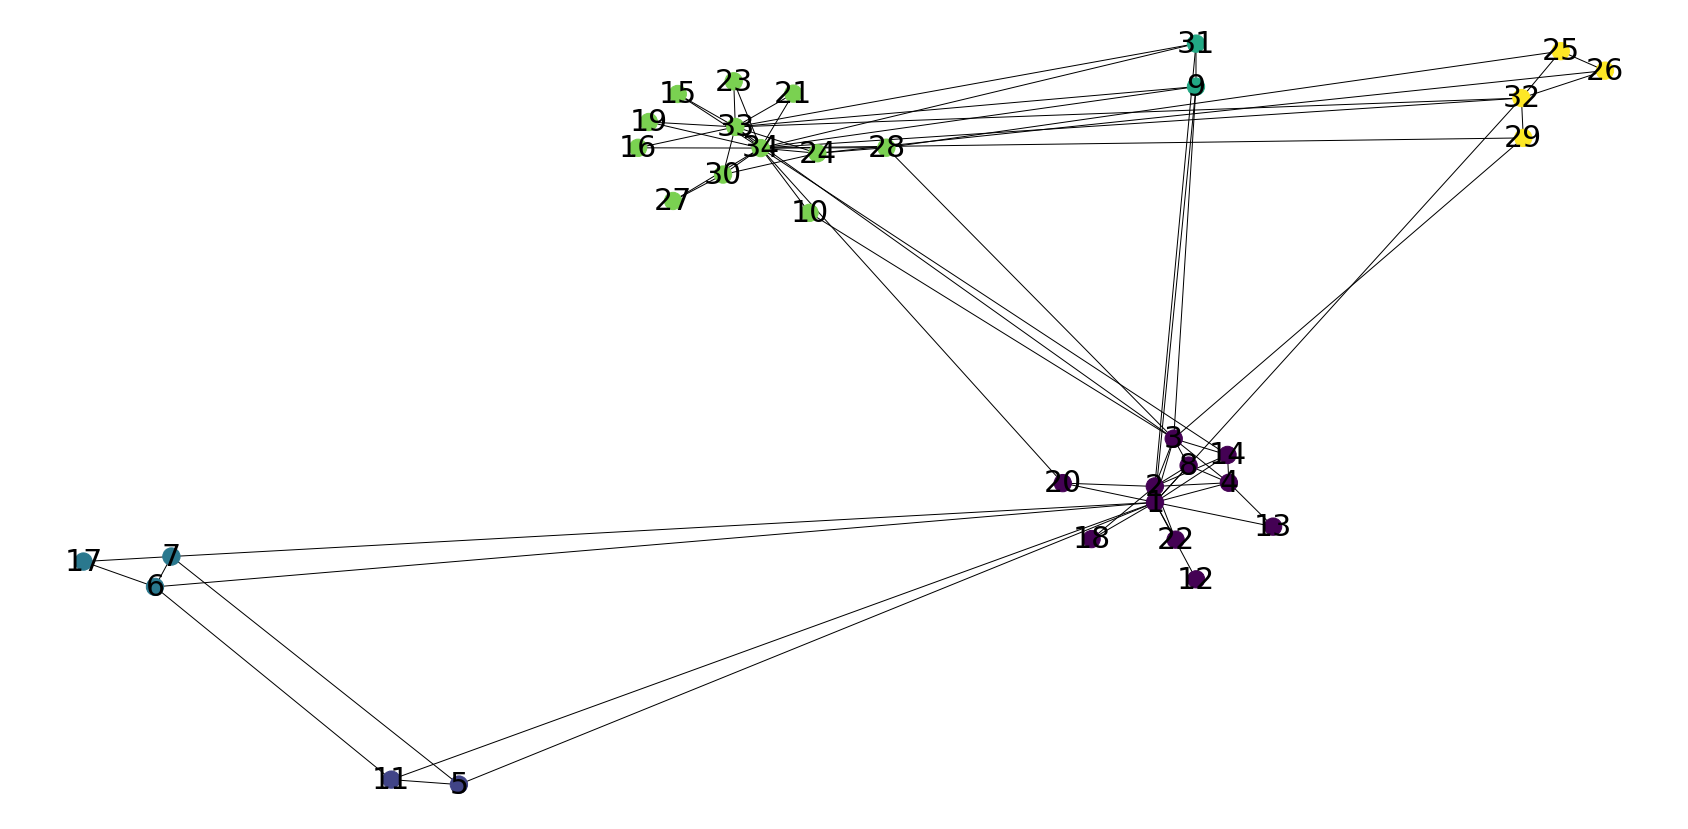

{1: array([  7.66268924, -11.68610258]),
 2: array([  7.65608413, -10.65114503]),
 3: array([ 8.30535631, -7.54964321]),
 4: array([ 10.20047675, -10.41231756]),
 5: array([-16.25475498, -30.        ]),
 6: array([-26.69638079, -17.17027682]),
 7: array([-26.13174618, -15.19978873]),
 8: array([ 8.81766497, -9.29591171]),
 9: array([ 9.0710973 , 15.29609653]),
 10: array([-4.20842318,  7.10484517]),
 11: array([-18.57696619, -29.67872109]),
 12: array([  9.07510526, -16.67994274]),
 13: array([ 11.72037755, -13.26017659]),
 14: array([10.15476496, -8.60731224]),
 15: array([-8.73456959, 14.81731883]),
 16: array([-10.09809219,  11.3249367 ]),
 17: array([-29.15444211, -15.52599787]),
 18: array([  5.4845529, -14.0670595]),
 19: array([-9.72797609, 13.00048108]),
 20: array([  4.49291119, -10.43579261]),
 21: array([-4.76401512, 14.84172385]),
 22: array([  8.37103422, -14.10463391]),
 23: array([-6.81189826, 15.64144144]),
 24: array([-3.93650153, 10.97214758]),
 25: array([21.60390258

In [133]:
com = np.array([0, 0, 0, 0, 1, 2, 2, 0, 3, 4, 1, 0, 0, 0, 4, 4, 2, 0, 4, 0, 4, 0,
        4, 4, 5, 5, 4, 4, 5, 4, 3, 5, 4, 4])
G = create_graph(cn._A, com)
plot_graph(G)